# Math behind a simple slot machine

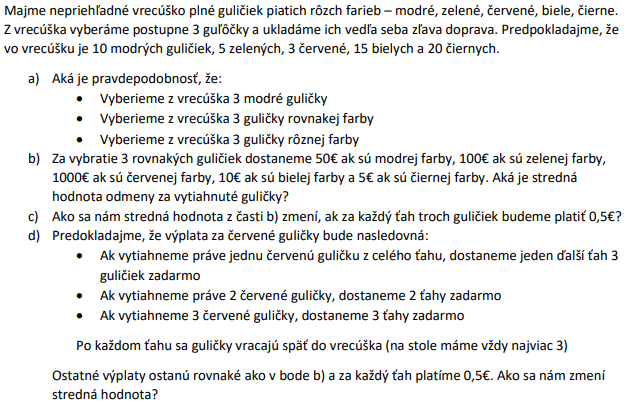

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import scipy.special
from scipy import stats
import math

# Monte Carlo Simulácia

In [ ]:
# Simulacia

# Pocet tahov
N = 1000000

# Vytiahnutie 3 guliciek za sebou bez opakovania
def draw_balls(n):
  bag = ['Cie'] * 20 + ['B'] * 15 + ['M'] * 10 + ['Z'] * 5 + ['Cer'] * 3
  balls = []
  for i in range(n):
    k = random.choice(bag)
    balls.append(k)
    bag.remove(k)

  return tuple(balls)

# Vyherne kombinacie
win_patterns = {
    ('Cie', 'Cie', 'Cie'): {'reward': 5, 'count': 0},
    ('B', 'B', 'B'): {'reward': 10, 'count': 0}, 
    ('M','M','M'): {'reward': 50, 'count': 0}, 
    ('Z','Z','Z'): {'reward': 100, 'count': 0}, 
    ('Cer', 'Cer', 'Cer'): {'reward': 1000, 'count': 0}
}

# Tracking variables
free_count = [0, 0, 0]
history = []
total_win = 0
averages = []

# Monte Carlo loop
for e in range(N):

    # Pay
    win = -0.5

    # Draw 3 balls
    balls = draw_balls(3)

    # $ Reward
    if balls in win_patterns:
      win += win_patterns[balls]['reward']
      win_patterns[balls]['count'] += 1

    # Free draw reward
    red_count = balls.count('Cer')
    if(red_count > 0):
      free_count[red_count-1] += 1
    free_draws = red_count
    
    while free_draws > 0:
        # Pay
        free_draws -= 1

        # Draw 3 balls
        balls = draw_balls(3)

        # $ Reward
        if balls in win_patterns:
          win += win_patterns[balls]['reward']
          win_patterns[balls]['count'] += 1
        
        # Free draw reward
        red_count = balls.count('Cer')
        if(red_count > 0):
          free_count[red_count - 1] += 1
        free_draws += red_count

    # Update tracking variables
    history.append(win)
    total_win += win
    averages.append(float(total_win) / N)

print(f'Priemerná výhra po {N} ťahoch je {total_win / N}€')

# Extrakcia dat na dalsie spracovanie
cashes_count = []
for i in range(5):
  cashes_count.append(list(win_patterns.values())[i]['count'])
winnings_counts = np.array(cashes_count[:-1] + free_count)
count = np.sum(winnings_counts)

Priemerná výhra po 1000000 ťahoch je 0.43055€


# Popisná štatistika výsledkov simulácie

In [ ]:
# Descriptive statistics
pd_history = pd.Series(history)

stat_list = [pd_history.count(),
             pd_history.mean(),
             pd_history.std(ddof=1),
             pd_history.min(),
             pd_history.max(),
             float(np.sum(cashes_count[:-1])) / pd_history.count()]

data = {'': stat_list}
df_history = pd.DataFrame(data, index=['Počet ťahov',
                                       'Priemerná výhra',
                                       'Smerodajná odchýlka',
                                       'Najmenšia výhra',
                                       'Najväčšia výhra',
                                       'Pravdepodobnosť peňažnej výhry'])

df_history


,
Počet ťahov,1000000.000000
Priemerná výhra,0.430550
Smerodajná odchýlka,7.950550
Najmenšia výhra,-0.500000
Najväčšia výhra,1054.500000
Pravdepodobnosť peňažnej výhry,0.088746


Intervaly spoľahlivosti pre priemernú výhru sú počítané podľa:

$$CI = mean \pm Z \cdot \frac{s}{\sqrt{N}},$$

Kde $mean$ je priemerná výhra (bodový odhad), $s$ je smerodajná odchýlka, $n$ je veľkosť vzorky a $Z$ je z-score získané zo štatistickej tabuľky.

Sú vypočítané 2 prípady, jeden kde $s$ je výpočítané z našej vzorky, druhý kde za $s$ je populačná smerodajná odchýlka.

In [ ]:
# Intervaly spolahlivosti - tabulka

def mean_confidence_interval(data, confidence, std_dev='sample'):
    a = 1.0 * np.array(data)
    n = len(a)
    mean = np.mean(a)
    
    SD = np.std(a, ddof=1)
    if std_dev == 'pop':
      SD = 8.659452852

    se = SD/np.sqrt(n)

    if confidence == 0.90:
      h = 1.645 * se
    elif confidence == 0.95:
      h = 1.960 * se
    elif confidence == 0.99:
      h = 2.576 * se
    else:
      return None

    return (np.round(mean-h, 5), np.round(mean+h, 5))

sample_intervals = [mean_confidence_interval(history, 0.90, 'sample'),
                    mean_confidence_interval(history, 0.95, 'sample'),
                    mean_confidence_interval(history, 0.99, 'sample')]

pop_intervals = [mean_confidence_interval(history, 0.90, 'pop'),
                    mean_confidence_interval(history, 0.95, 'pop'),
                    mean_confidence_interval(history, 0.99, 'pop')]

data = {'Použitá smerodajná odchýlka vzorky': sample_intervals,
        'Použitá smerodajná odchýlka populácie (Z excelu)': pop_intervals
        }

symbols = ['90% Interval spoľahlivosti priemernej výhry', '95% Interval spoľahlivosti priemernej výhry', '99% Interval spoľahlivosti priemernej výhry']
df = pd.DataFrame(data, index=symbols)
df


,Použitá smerodajná odchýlka vzorky,Použitá smerodajná odchýlka populácie (Z excelu)
90% Interval spoľahlivosti priemernej výhry,"(0.41747, 0.44363)","(0.41631, 0.44479)"
95% Interval spoľahlivosti priemernej výhry,"(0.41497, 0.44613)","(0.41358, 0.44752)"
99% Interval spoľahlivosti priemernej výhry,"(0.41007, 0.45103)","(0.40824, 0.45286)"


Pre N = 50000, grafy intervalov spoľahlivosti vyzerajú takto (len insertnuté obrázky, výpočet trvá dlho):

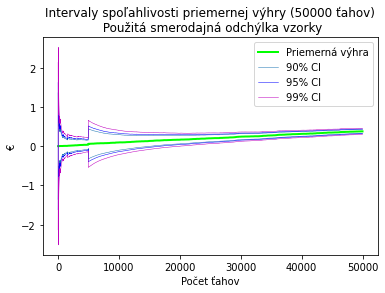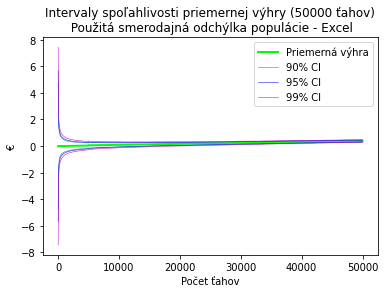


# Analýza početnosti jednotlivých výhier

In [ ]:
# Analyza pocetnosti jednotlivych vyhier - Tabulka

data = {'Absolútna početnosť': winnings_counts,
        'Relatívna početnosť': winnings_counts / count,
        'Relatívna početnosť (%)': (winnings_counts / count) * 100,
        'Pravdepodobnosť na 1 klasický ťah (%)': (winnings_counts / N) * 100
        }

symbols = ['3Cie', '3B', '3M', '3Z', '1Cer', '2Cer', '3Cer']
df = pd.DataFrame(data, index=symbols)

df

,Absolútna početnosť,Relatívna početnosť,Relatívna početnosť (%),Pravdepodobnosť na 1 klasický ťah (%)
3Cie,58656,0.205566,20.556601,5.8656
3B,23342,0.081804,8.180445,2.3342
3M,6199,0.021725,2.172504,0.6199
3Z,549,0.001924,0.192403,0.0549
1Cer,188791,0.661638,66.163756,18.8791
2Cer,7763,0.027206,2.720624,0.7763
3Cer,39,0.000137,0.013668,0.0039


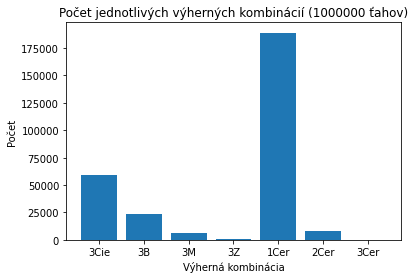

In [ ]:
# Analyza pocetnosti jednotlivych vyhier - Graf

# plt.rcParams["figure.figsize"] = (4,3)
plt.bar(symbols, winnings_counts, color='tab:blue')
plt.title(f'Počet jednotlivých výherných kombinácií ({N} ťahov)')
plt.ylabel('Počet')
plt.xlabel('Výherná kombinácia');